In [1]:
# Import library
import numpy as np
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import logging

In [2]:
#set up logging 
logging.basicConfig(level=logging.INFO,format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()

In [3]:
# Load Dataset
train = pd.read_csv('train.csv')

In [4]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test = pd.read_csv('test.csv')

In [6]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [7]:
store = pd.read_csv('store.csv')

In [8]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Isolate the Rossmann Store Sales Dataset into Time Series Data

In [9]:
logger.info("Aggregating sales data by date...")

2024-10-20 13:39:14,663 - INFO - Aggregating sales data by date...


In [10]:
# Aggregate sales data by store
store_sales = train.groupby(['Date'], as_index=False)['Sales'].sum()

In [31]:
# Focus on a single store or aggregate sales across stores
store_id = 1  # You can loop over multiple stores or focus on one
store_data = train[train['Store'] == store_id]

In [32]:
# Sort data by date
store_sales = store_sales.sort_values(by='Date')

In [33]:
logger.info("Sales data aggregated and sorted by date.")

2024-10-20 13:54:04,527 - INFO - Sales data aggregated and sorted by date.


In [34]:
# Sort by date
store_data = store_data.sort_index()

# Isolate the 'Sales' column for time series analysis
sales_data = store_data['Sales']

# Check Whether Your Time Series Data is Stationary

In [35]:
# import some important library
from statsmodels.tsa.stattools import adfuller

In [36]:
logger.info("Checking for stationarity using the Augmented Dickey-Fuller test...")

2024-10-20 13:54:07,634 - INFO - Checking for stationarity using the Augmented Dickey-Fuller test...


In [37]:
# Perform Augmented Dickey-Fuller test
result = adfuller(sales_data.dropna())

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -4.37478361258119
p-value: 0.0003288655352513879


In [38]:
# Conclusion on stationarity
if result[1] <= 0.05:
    print("Data is stationary")
    logger.info("Data is stationary.")
else:
    print("Data is not stationary")
    logger.info("Data is not stationary. Differencing may be required.")

2024-10-20 13:54:09,189 - INFO - Data is stationary.


Data is stationary


In [39]:
# Difference Your Time Series Data 
if result[1] >= 0.05:
    logger.info("Differencing the data to make it stationary...")
    store_sales['Sales_diff'] = store_sales['Sales'].diff().dropna()
    logger.info("Data differenced.")
else:
    store_sales['Sales_diff'] = store_sales['Sales']

# Check for Autocorrelation and Partial Autocorrelation

In [40]:
# import some library 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

2024-10-20 13:54:12,526 - INFO - Plotting autocorrelation and partial autocorrelation...


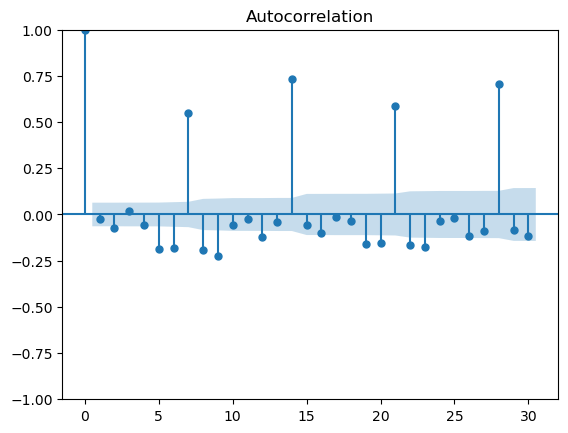

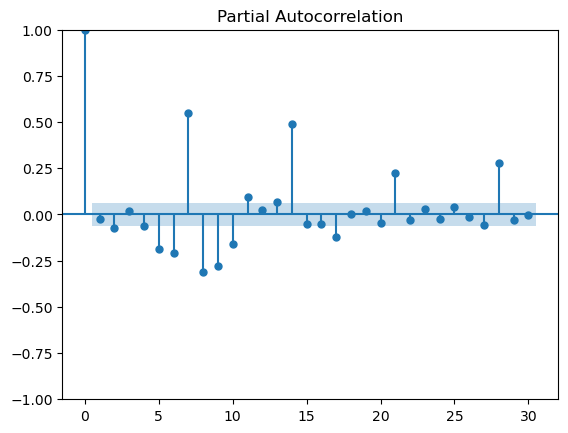

In [41]:
# Plotting Autocorrelation and Partial Autocorrelation 
logger.info("Plotting autocorrelation and partial autocorrelation...")
plot_acf(store_sales['Sales_diff'].dropna())
plot_pacf(store_sales['Sales_diff'].dropna())
plt.show()

# Transform the Time Series Data into Supervised Learning Data

In [42]:
logger.info("Transforming time series data into supervised learning data...")

2024-10-20 13:54:14,219 - INFO - Transforming time series data into supervised learning data...


In [45]:
# Transform Time Series Data into Supervised Learning Data 
def create_lagged_features(data, lag=1):
    x, y = [], []
    for i in range(len(data)-lag):
        x.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(x), np.array(y)

# Example with 7 lags (one week)
n_lags = 7
x, y = create_lagged_features(store_sales['Sales_diff'].values, n_lags)
x = x.reshape((x.shape[0], x.shape[1], 1))  # Reshape for LSTM input

In [46]:
logger.info("Lagged features created.")

2024-10-20 13:57:53,064 - INFO - Lagged features created.


# Scale Your Data in the (-1, 1) Range

In [47]:
# Import some library
from sklearn.preprocessing import MinMaxScaler

In [48]:
logger.info("Scaling the data...")

2024-10-20 13:57:55,959 - INFO - Scaling the data...


In [49]:
scaler = MinMaxScaler(feature_range=(-1, 1))
x_scaled = scaler.fit_transform(x.reshape(-1, 1)).reshape(x.shape)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).reshape(-1)

In [50]:
logger.info("Data scaled to range (-1, 1).")

2024-10-20 13:57:57,002 - INFO - Data scaled to range (-1, 1).


# Build an LSTM Regression Model to Predict the Next Sale

In [51]:
# Import some important library
import tensorflow as tf 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

In [52]:
logger.info("Building the LSTM model...")

2024-10-20 13:58:14,114 - INFO - Building the LSTM model...


In [53]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))

In [54]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [55]:
logger.info("Training the LSTM model...")

2024-10-20 13:58:14,599 - INFO - Training the LSTM model...


In [56]:
# Train the model
model.fit(x_scaled, y_scaled, epochs=20, batch_size=32)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.1752
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1580
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1635
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1550
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1247
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1098
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0951
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0938
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0875
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0845
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0900
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0812
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0759
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0860
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0718
Epoch 16/20


# Make Predictions

In [57]:
logger.info("Making predictions...")

2024-10-20 13:58:27,526 - INFO - Making predictions...


In [58]:
# Assuming you have a test set x_test_scaled
y_pred_scaled = model.predict(x_scaled)

# Inverse transform the predictions
y_pred = scaler.inverse_transform(y_pred_scaled)

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


In [59]:
logger.info("Predictions made.")

2024-10-20 13:58:28,670 - INFO - Predictions made.


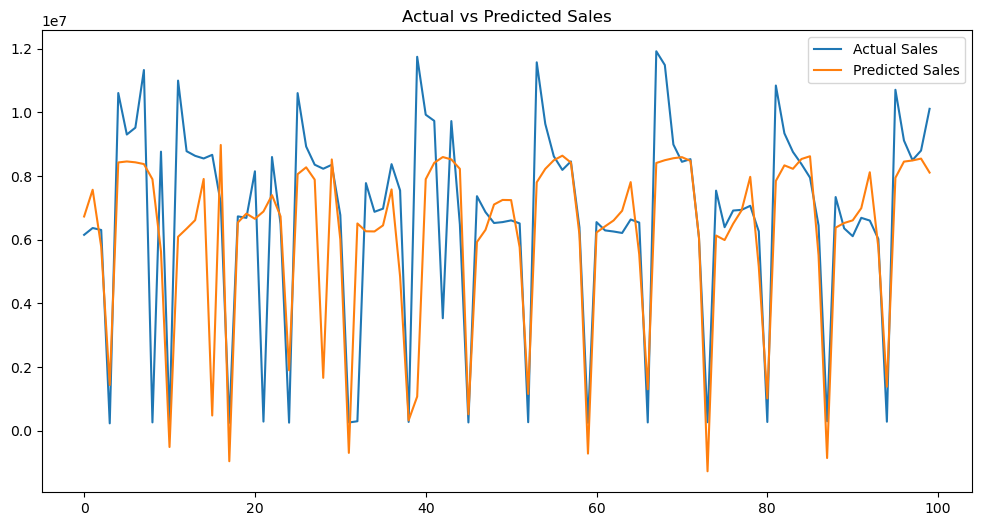

In [60]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y[-100:], label='Actual Sales')
plt.plot(y_pred[-100:], label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

# Steps to Serve Predictions Using MLflow

In [61]:
# Import some important library
import mlflow
import mlflow.keras
import tensorflow as tf
from datetime import datetime

In [62]:
# Start an MLflow run
with mlflow.start_run(run_name="LSTM_Sales_Prediction"):
    # Log parameters
    mlflow.log_param("n_lags", n_lags)
    mlflow.log_param("epochs", 20)
    mlflow.log_param("batch_size", 32)

In [63]:
# Train the model (as previously defined)
model = Sequential()
model.add(LSTM(50, input_shape=(n_lags, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_scaled, y_scaled, epochs=20, batch_size=32)


Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1800
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1557
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1526
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1350
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1218
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1137
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0970
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0854
Epoch 9/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0801
Epoch 10/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0915
Epoch 11/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0795
Epoch 12/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0876
Epoch 13/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0710
Epoch 14/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0777
Epoch 15/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0795
Epoch 16/20
30/30 

In [66]:
# Log the model
mlflow.keras.log_model(model, "model")

2024/10/20 14:22:16 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2024/10/20 14:22:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [67]:
# Log metrics
y_pred_scaled = model.predict(x_scaled)
y_pred = scaler.inverse_transform(y_pred_scaled)
mse = tf.keras.losses.MeanSquaredError()(y_scaled, y_pred_scaled).numpy()
mlflow.log_metric("mse", mse)

print(f"Model logged with MSE: {mse}")

# Model is now logged with MLflow

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Model logged with MSE: 0.07164790481328964
